# Импортируем библиотеку

In [27]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import seaborn as sns
import matplotlib.pyplot as plt

# Настраиваем параметры

In [9]:
# Параметры
EMBEDDING_DIM = 256
UNITS = 512
MAX_VOCAB_SIZE = 5000
MAX_LENGTH = 20
BATCH_SIZE = 32
IMAGE_SIZE = (299, 299)

In [7]:
# Путь к данным
CSV_PATH = "/home/sb/Downloads/Image-Captioning/flickr30k_images/results.csv"
IMAGE_DIR = "/home/sb/Downloads/Image-Captioning/flickr30k_images/flickr30k_images"

# Загружаем данные

In [18]:
# Загрузка данных
df = pd.read_csv(CSV_PATH, delimiter="|").rename(columns={" comment": "comment"}).drop([' comment_number'], axis=1)
images = df['image_name'].values
captions = df['comment'].values
df

,image_name,comment
0,1000092795.jpg,Two young guys with shaggy hair look at their...
1,1000092795.jpg,"Two young , White males are outside near many..."
2,1000092795.jpg,Two men in green shirts are standing in a yard .
3,1000092795.jpg,A man in a blue shirt standing in a garden .
4,1000092795.jpg,Two friends enjoy time spent together .
...,...,...
158910,998845445.jpg,A man in shorts and a Hawaiian shirt leans ov...
158911,998845445.jpg,"A young man hanging over the side of a boat ,..."
158912,998845445.jpg,A man is leaning off of the side of a blue an...
158913,998845445.jpg,"A man riding a small boat in a harbor , with ..."


# EDA

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158915 entries, 0 to 158914
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   image_name  158915 non-null  object
 1   comment     158914 non-null  object
dtypes: object(2)
memory usage: 2.4+ MB


In [21]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 158914 entries, 0 to 158914
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   image_name  158914 non-null  object
 1   comment     158914 non-null  object
dtypes: object(2)
memory usage: 3.6+ MB


In [25]:
count_words = df['comment'].apply(lambda x: len(x.split()))
count_words

0         17
1         11
2         11
3         11
4          7
          ..
158910    25
158911    25
158912    23
158913    18
158914    17
Name: comment, Length: 158914, dtype: int64

In [26]:
count_simbols = df['comment'].apply(lambda x: len(x))
count_simbols

0          84
1          55
2          49
3          45
4          40
         ... 
158910    118
158911    106
158912     90
158913     83
158914     78
Name: comment, Length: 158914, dtype: int64

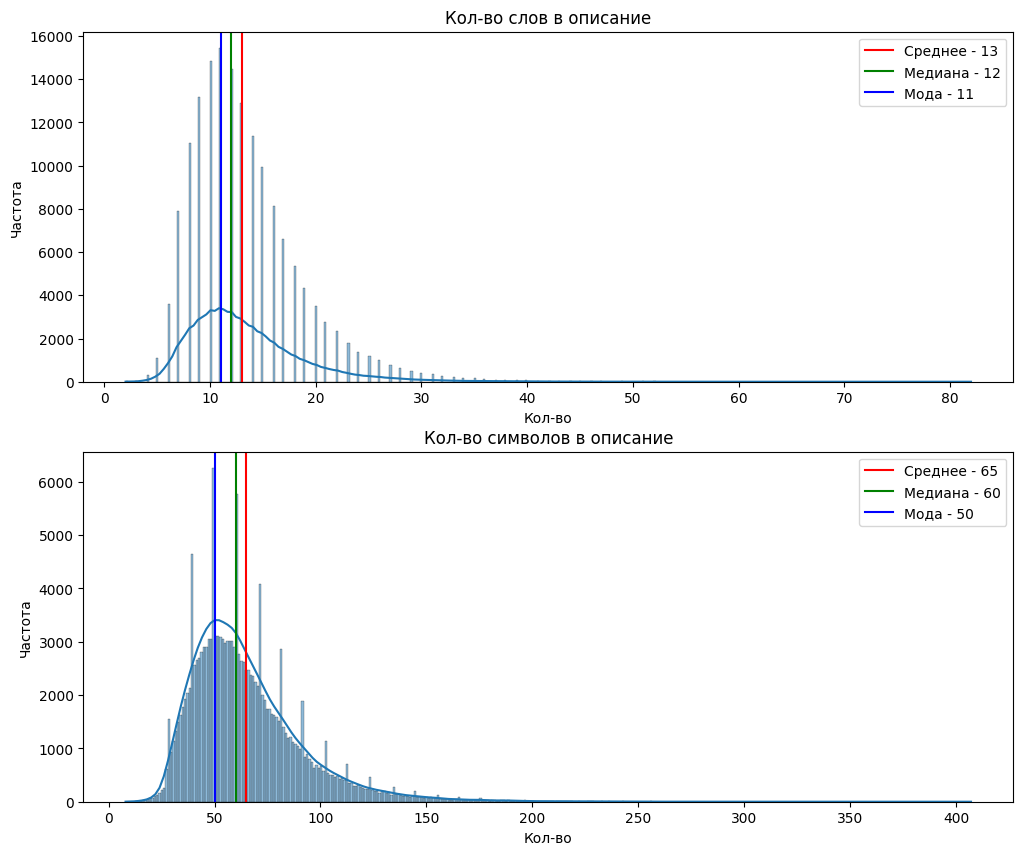

In [51]:
fig, axe = plt.subplots(2, 1, figsize=(12, 10))

mean1 = round(count_words.mean())
median1 = round(count_words.median())
mode1 = round(count_words.mode()[0])

mean2 = round(count_simbols.mean())
median2 = round(count_simbols.median())
mode2 = round(count_simbols.mode()[0])


sns.histplot(x=count_words, ax=axe[0], kde=True)

axe[0].axvline(mean1, c='r', label=f'Среднее - {mean1}')
axe[0].axvline(median1, c='g', label=f'Медиана - {median1}')
axe[0].axvline(mode1, c='b', label=f'Мода - {mode1}')

axe[0].set_title("Кол-во слов в описание")
axe[0].set_xlabel("Кол-во")
axe[0].set_ylabel("Частота")
axe[0].legend()

sns.histplot(x=count_simbols, ax=axe[1], kde=True)

axe[1].set_title("Кол-во символов в описание")
axe[1].set_xlabel("Кол-во")
axe[1].set_ylabel("Частота")

axe[1].axvline(mean2, c='r', label=f'Среднее - {mean2}')
axe[1].axvline(median2, c='g', label=f'Медиана - {median2}')
axe[1].axvline(mode2, c='b', label=f'Мода - {mode2}')
axe[1].legend()

plt.show()

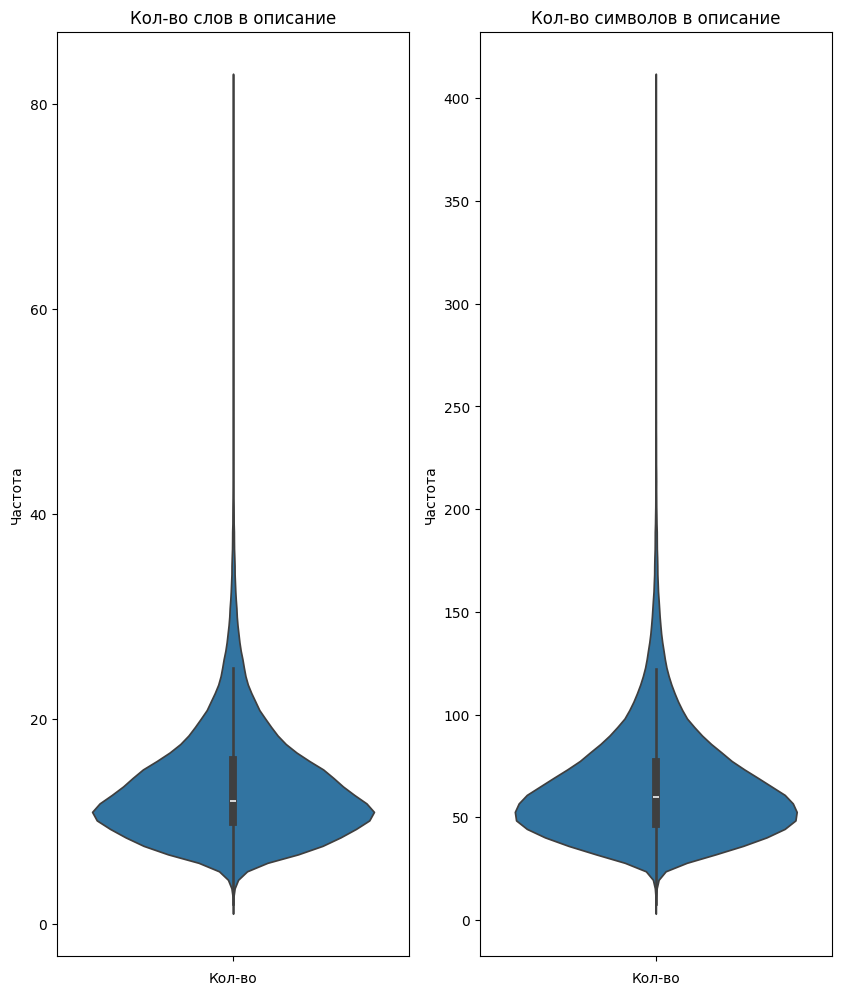

In [56]:
fig, axe = plt.subplots(1, 2, figsize=(10, 12))


sns.violinplot(y=count_words, ax=axe[0])


axe[0].set_title("Кол-во слов в описание")
axe[0].set_ylabel("Кол-во")
axe[0].set_xlabel("Частота")

sns.violinplot(y=count_simbols, ax=axe[1])

axe[1].set_title("Кол-во символов в описание")
axe[1].set_ylabel("Кол-во")
axe[1].set_xlabel("Частота")

plt.show()

In [ ]:
# Предобученный энкодер
def build_encoder():
    base_model = InceptionV3(weights='imagenet')
    base_model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)
    for layer in base_model.layers:
        layer.trainable = False
    return base_model

encoder = build_encoder()

In [ ]:
# Обработка изображений
def preprocess_image(image_path):
    img = load_img(image_path, target_size=IMAGE_SIZE)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return encoder.predict(img)

In [ ]:
# Токенизация текстов
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<unk>")
tokenizer.fit_on_texts(captions)
sequences = tokenizer.texts_to_sequences(captions)
word_index = tokenizer.word_index
index_word = {v: k for k, v in word_index.items()}
vocab_size = min(MAX_VOCAB_SIZE, len(word_index)) + 1

In [ ]:
# Паддинг последовательностей
captions_padded = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post')

In [ ]:
# Подготовка изображений
image_features = np.array([preprocess_image(os.path.join(IMAGE_DIR, img)) for img in images])

In [ ]:
# Модель декодера
def build_decoder(vocab_size, embedding_dim, units):
    image_input = Input(shape=(2048,))
    img_embedding = Dense(EMBEDDING_DIM, activation="relu")(image_input)

    text_input = Input(shape=(MAX_LENGTH,))
    text_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)(text_input)

    lstm_input = tf.concat([tf.expand_dims(img_embedding, axis=1), text_embedding], axis=1)
    lstm_output, _ = LSTM(units, return_sequences=True, return_state=True)(lstm_input)
    outputs = Dense(vocab_size, activation="softmax")(lstm_output)
    
    return Model([image_input, text_input], outputs)

decoder = build_decoder(vocab_size, EMBEDDING_DIM, UNITS)

In [ ]:
# Компиляция модели
decoder.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

In [ ]:
# Подготовка данных для обучения
X_img = image_features
X_seq = captions_padded[:, :-1]
Y = captions_padded[:, 1:]

In [ ]:
# Обучение модели
decoder.fit([X_img, X_seq], Y, epochs=10, batch_size=BATCH_SIZE)

In [ ]:
# Генерация текста
def generate_caption(image_path, max_length=MAX_LENGTH):
    image_feature = preprocess_image(image_path)
    input_seq = [tokenizer.word_index.get('<start>', 1)]
    result = []

    for _ in range(max_length):
        padded_seq = pad_sequences([input_seq], maxlen=max_length, padding='post')
        predictions = decoder.predict([image_feature, padded_seq])
        predicted_id = np.argmax(predictions[0, -1, :])
        word = index_word.get(predicted_id, '<unk>')

        if word == '<end>':
            break
        result.append(word)
        input_seq.append(predicted_id)

    return ' '.join(result)

In [ ]:
# Тестирование
print(generate_caption("/home/sb/Downloads/Image-Captioning/flickr30k_images/flickr30k_images/36979.jpg"))